In [1]:
from qiskit.ml.datasets import breast_cancer
from qiskit import QuantumCircuit
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\qiskit\aqua\operators\operator_globals.py:46: DeprecationWarning: `from_label` is deprecated and will be removed no earlier than 3 months after the release date. Use Pauli(label) instead.
  X = make_immutable(PrimitiveOp(Pauli.from_label('X')))


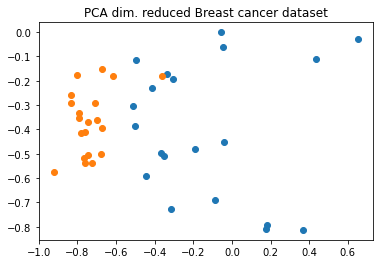

['A', 'B']


In [2]:
training_size=20
test_size=10

n=2
_, training_input, test_input, class_labels= \
            breast_cancer(training_size=training_size, test_size=test_size, n=n, plot_data=True)
print(class_labels)

<ipython-input-3-505e1e68f7a9>:5: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circuit=feature_map.combine(var_form)


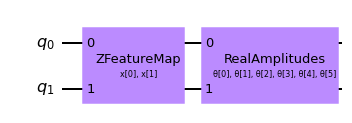

In [3]:
sv=Statevector.from_label('0'*n)
feature_map=ZFeatureMap(n,reps=2)
var_form=RealAmplitudes(n,reps=2)

circuit=feature_map.combine(var_form)
circuit.draw(output='mpl')

In [4]:
def get_data_dic(params, x):
    parameter={}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameter[p]=x[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameter[p]=params[i]
    return parameter

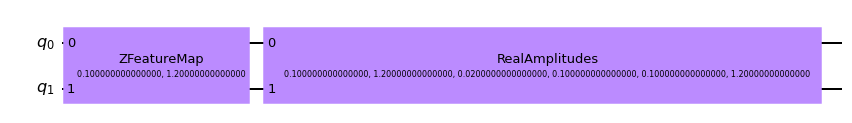

In [5]:
data=[0.1, 1.2]
params=np.array([0.1, 1.2, 0.02, 0.1,0.1, 1.2, 0.02, 0.1])
circ_=circuit.assign_parameters(get_data_dic(params, data))
circ_.draw(output='mpl', plot_barriers=True)

In [6]:
def assign_label(bit_string, class_labels):
    hamming_weight=sum([int(k) for k in list(bit_string)])
    is_odd_parity=hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

In [7]:
def return_probabilities(counts, class_labels):
    shots=sum(counts.values())
    result={class_labels[0]:0, class_labels[1]:0}
    for key,item in counts.items():
        label=assign_label(key,class_labels)
        result[label] +=counts[key]/shots
    return result

In [8]:
return_probabilities({'00':10,'10':10}, class_labels)

{'A': 0.5, 'B': 0.5}

In [9]:
def classify(x_list, params, class_labels):
    qc_list=[]
    for x in x_list:
        circ_=circuit.assign_parameters(get_data_dic(params, x))
        qc=sv.evolve(circ_)
        qc_list +=[qc]
    probs=[]
    for qc in qc_list:
        counts=qc.probabilities_dict()
        prob=return_probabilities(counts,class_labels)
        probs+=[prob]
    return probs

In [10]:
x=np.asarray([[0.5,0.5]])
classify(x, params=np.array([0.8,-0.5,1.5,0, 5,0.8,-0.5,1.5,0, 5]),class_labels=class_labels)

[{'A': 0.8559447255664226, 'B': 0.14405527443357735}]

In [11]:
def cost_estimate_sigmoid(probs, expected_label):
    p=probs.get(expected_label)
    sig=None
    if np.isclose(p,0.0):
        sig=1
    elif np.isclose(p,1.0):
        sig=0
    else:
        denominator=np.sqrt(2*p*(1-p))
        x=np.sqrt(200)*(0.5-p)/denominator
        sig=1/(1+np.exp(-x))
    return sig

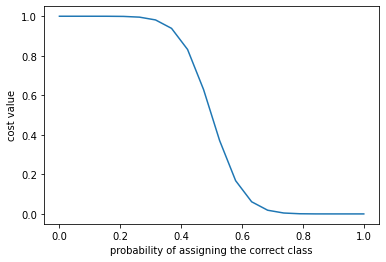

In [12]:
x=np.linspace(0,1,20)
y=[cost_estimate_sigmoid({'A':x_,'B':1-x_}, 'A') for x_ in x]
plt.plot(x,y)
plt.xlabel('probability of assigning the correct class')
plt.ylabel('cost value')
plt.show()

In [13]:
def cost_function(training_input, class_labels, params, shots=100, print_value=False):
    cost=0
    training_labels=[]
    traning_samples=[]
    for label,samples in training_input.items():
        for sample in samples:
            training_labels += [label]
            traning_samples += [sample]
    
    probs=classify(traning_samples,params,class_labels)
    for i, prob in enumerate(probs):
        cost += cost_estimate_sigmoid(prob,training_labels[i])
    cost /=len(traning_samples)
    
    if print_value:
        print('%.4f' % cost)
        
    return cost

In [14]:
cost_function(training_input,class_labels,params)

0.8298316032546813

In [15]:
optimizer=COBYLA(maxiter=100)
objective_function= lambda params: cost_function(training_input, class_labels, params, print_value=True)
np.random.seed(137)
init_params= 2*np.pi*np.random.rand(n*(1)*2*2)
opt_params, value, _ =optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
print()
print('opt_params', opt_params)
print('opt_value', value)

0.5054
0.5024
0.5113
0.5020
0.4934
0.4381
0.7900
0.4381
0.4381
0.1930
0.2331
0.2398
0.2625
0.3239
0.0988
0.0922
0.2366
0.4662
0.1231
0.4143
0.1637
0.1313
0.1758
0.1782
0.0906
0.0886
0.1699
0.0956
0.1221
0.0874
0.1454
0.0940
0.0948
0.1060
0.1160
0.0879
0.0880
0.0927
0.0872
0.0917
0.0867
0.0922
0.0866
0.0876
0.0869
0.0896
0.0883
0.0865
0.0871
0.0865
0.0864
0.0865
0.0864
0.0866
0.0864
0.0873
0.0861
0.0861
0.0860
0.0860
0.0861
0.0861
0.0860
0.0860
0.0859
0.0858
0.0857
0.0856
0.0855
0.0854
0.0853
0.0852
0.0852
0.0851
0.0851
0.0851
0.0850
0.0849
0.0849
0.0849
0.0849
0.0849
0.0849
0.0848
0.0848
0.0847
0.0848
0.0848
0.0847
0.0846
0.0846
0.0846
0.0847
0.0846
0.0845
0.0845
0.0844
0.0845
0.0846
0.0844

opt_params [5.96651667 0.68398688 5.31282381 5.65492124 4.9984635  1.72968436
 5.01231438 0.22170083]
opt_value 0.08441287583193458


---------------------------------------------
Data point: [-0.10389794  0.17924751]
Label: A
Assigned: A
Probabilities {'A': 0.9278548893496785, 'B': 0.07214511065032167}
Classification CORRECT
---------------------------------------------
Data point: [-0.53086407 -0.4573074 ]
Label: A
Assigned: A
Probabilities {'A': 0.5218317508227095, 'B': 0.47816824917729045}
Classification CORRECT
---------------------------------------------
Data point: [-0.21040012 -0.42492679]
Label: A
Assigned: A
Probabilities {'A': 0.8320443851077399, 'B': 0.16795561489226007}
Classification CORRECT
---------------------------------------------
Data point: [-0.02115007 -0.46893251]
Label: A
Assigned: A
Probabilities {'A': 0.9092298455816468, 'B': 0.09077015441835318}
Classification CORRECT
---------------------------------------------
Data point: [-0.20818445 -0.4872755 ]
Label: A
Assigned: A
Probabilities {'A': 0.827214322179374, 'B': 0.17278567782062604}
Classification CORRECT
-------------------------------

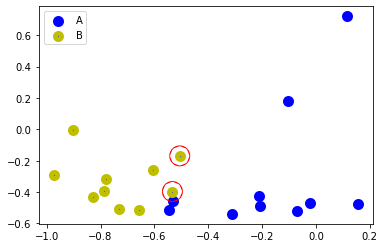

In [16]:
test_label_0_x=[x[0] for x in test_input[class_labels[0]]]
test_label_0_y=[x[1] for x in test_input[class_labels[0]]]
test_label_1_x=[x[0] for x in test_input[class_labels[1]]]
test_label_1_y=[x[1] for x in test_input[class_labels[1]]]

test_label_misclassified_x=[]
test_label_misclassified_y=[]

for label, samples in test_input.items():
    result=classify(samples, opt_params, class_labels)
    for i, result in enumerate(result):
        assigned_label=class_labels[np.argmax([p for p in result.values()])]
        print('---------------------------------------------')
        print('Data point:', samples[i])
        print('Label:',label)
        print('Assigned:', assigned_label)
        print('Probabilities', result)
        if label != assigned_label:
            print('Classification:', 'INCORRECT')
            test_label_misclassified_x += [samples[i][0]]
            test_label_misclassified_y += [samples[i][1]]
            
        else:
            print('Classification', 'CORRECT')
            
        
total= len(test_label_0_x)+len(test_label_1_x)
num_misclassified=len(test_label_misclassified_x)
print()
print(100*(1-num_misclassified/total), '% of test data was correctly classified')

plt.figure()
plt.scatter(test_label_0_x,test_label_0_y,c='b',label=class_labels[0],linewidth=5)
plt.scatter(test_label_1_x,test_label_1_y,c='b',label=class_labels[1],linewidth=5, edgecolors='y')
plt.scatter(test_label_misclassified_x, test_label_misclassified_y, linewidth=20, s=1, facecolors='none', edgecolors='r')
plt.legend()
plt.show()